# Sentiment Data Exploration

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Raw Data

First let's look at some of the raw data labelled by both human classifiers and Chat-GPT.

In [21]:
# One of the datasets labelled both by human classifiers and chat-gpt
fin_phrasebank = pd.read_csv('../../data/classified-data/financial_phrasebank.csv')
fin_phrasebank = fin_phrasebank[['Headlines','Manual Sentiment', 'GPT Sentiment', 'FinRoberta Sentiment']]

aspect_analysis = pd.read_csv('../../data/classified-data/aspect_based_analysis.csv')
aspect_analysis = aspect_analysis[['Headlines','Manual Sentiment', 'GPT Sentiment', 'FinRoberta Sentiment']]

raw_df = pd.concat([fin_phrasebank, aspect_analysis], ignore_index=True)
raw_df.sample(5)

,Headlines,Manual Sentiment,GPT Sentiment,FinRoberta Sentiment
6630,Bets on crude surge ahead of OPEC meet,Positive,Positive,Positive
9796,"Fitch affirms Tata Motors, JLR with stable out...",Neutral,Positive,Positive
5421,Heritage Foods to reward shareholders with 1:1...,Neutral,Positive,Neutral
2016,"In the beginning of this year, Wartsila had se...",Positive,Neutral,Positive
1358,The company designs and manufactures high-qual...,Neutral,Neutral,Neutral


In [22]:
# Get percentage of rows classified the same by both human and chat-gpt
gpt_performance = raw_df[raw_df['GPT Sentiment'] == raw_df['Manual Sentiment']].shape[0] / raw_df.shape[0]
finroberta_performance = raw_df[raw_df['FinRoberta Sentiment'] == raw_df['Manual Sentiment']].shape[0] / raw_df.shape[0]

print(f'GPT performance: {gpt_performance:.2%}')
print(f'FinRoberta performance: {finroberta_performance:.2%}')

GPT performance: 80.19%
FinRoberta performance: 77.83%


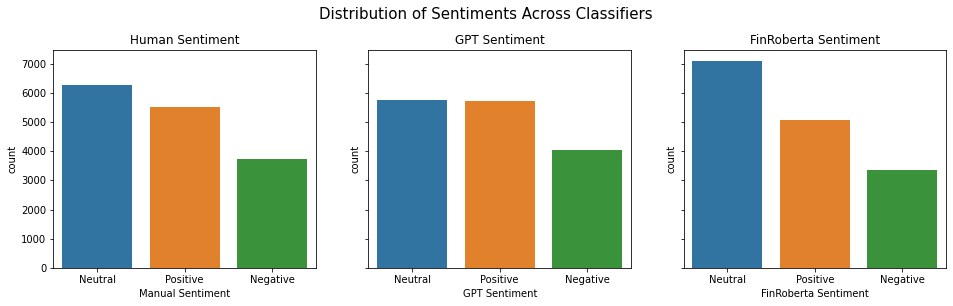

In [23]:
# Plot the distribution of sentiments for each classifier
order = ['Neutral', 'Positive', 'Negative']
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
sns.countplot(ax=axes[0], x='Manual Sentiment', data=raw_df, order=order)
sns.countplot(ax=axes[1], x='GPT Sentiment', data=raw_df, order=order)
sns.countplot(ax=axes[2], x='FinRoberta Sentiment', data=raw_df, order=order)
axes[0].set_title('Human Sentiment')
axes[1].set_title('GPT Sentiment')
axes[2].set_title('FinRoberta Sentiment')
plt.suptitle("Distribution of Sentiments Across Classifiers", fontsize=15, y=1.03)
plt.show()

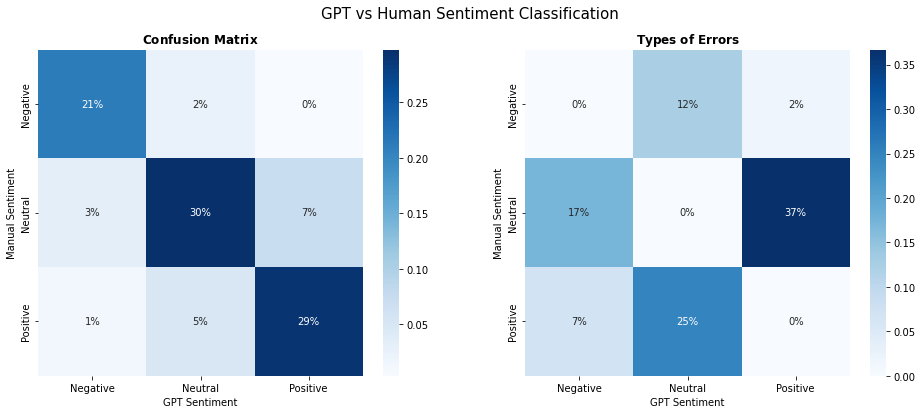

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

conf_mat = pd.crosstab(raw_df['Manual Sentiment'], raw_df['GPT Sentiment'])
sns.heatmap(conf_mat / conf_mat.sum().sum(), ax=axes[0], annot=True, fmt='.0%', cmap='Blues')
axes[0].set_title('$\\bf{Confusion\,\,Matrix}$')

error_rates = conf_mat.copy()
for i in range(len(error_rates)):
    error_rates.iloc[i,i] = 0
sns.heatmap(error_rates / error_rates.sum().sum(), ax=axes[1], annot=True, fmt='.0%', cmap='Blues')
axes[1].set_title('$\\bf{Types\,\,of\,\,Errors}$')

plt.suptitle('GPT vs Human Sentiment Classification', fontsize=15, y=0.98)
plt.show()

In [25]:
pos_neu = raw_df[(raw_df['Manual Sentiment'] == 'Positive') & (raw_df['GPT Sentiment'] == 'Neutral')]
pos_neu = pos_neu['Headlines'].sample(7).values.tolist()
print('\033[1m' + 'Human sentiment: Positive, GPT sentiment: Neutral' + '\033[0m')
for row in pos_neu:
    print(f'  "{row}"')
print()

neu_pos = raw_df[(raw_df['Manual Sentiment'] == 'Neutral') & (raw_df['GPT Sentiment'] == 'Positive')]
neu_pos = neu_pos['Headlines'].sample(7).values.tolist()
print('\033[1m' + 'Human sentiment: Neutral, GPT sentiment: Positive' + '\033[0m')
for row in neu_pos:
    print(f'  "{row}"')

Human sentiment: Positive, GPT sentiment: Neutral
  "Brand value in Deccan Chronicle still intact: mbareesh Baliga, Way2Wealth Brokers"
  "Overall, 50 percent of respondents were confident about their security when banking online"
  "Citigroup, Inc ( NYSE : C ) has announced that its Global Transaction Services ( GTS ) business has been awarded a new mandate by Finland-based Pohjola Bank Group"
  "Foreign currency bonds by non-financial companies to hit a high"
  "Saatchi & Saatchi adds creative muscle with new appointments, Elevates Mithun Mirji to Singapore for a newly created role"
  "The company also said that in Poland a profitability program has been launched at the Oborniki steel frame and sandwich panel plant"
  "Press release 9 October 2009 Ruukki has signed a contract to deliver and install the steel structures for a bridge over the Kyronsalmi strait in Savonlinna, Finland"

Human sentiment: Neutral, GPT sentiment: Positive
  "The report profiles 158 companies including many 

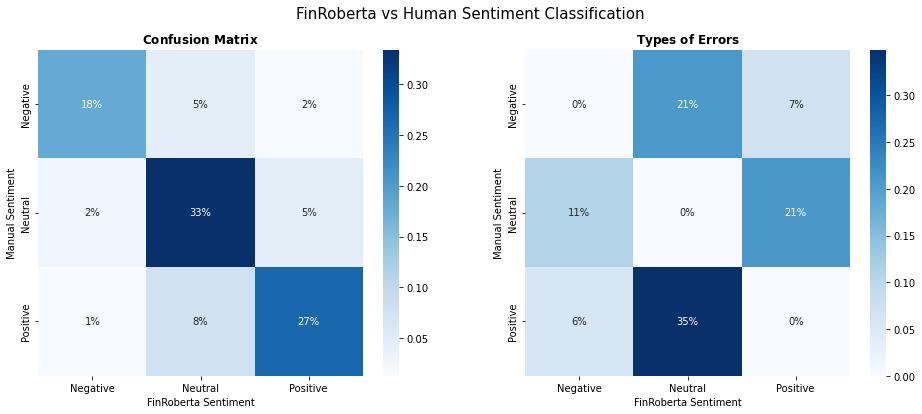

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

conf_mat = pd.crosstab(raw_df['Manual Sentiment'], raw_df['FinRoberta Sentiment'])
sns.heatmap(conf_mat / conf_mat.sum().sum(), ax=axes[0], annot=True, fmt='.0%', cmap='Blues')
axes[0].set_title('$\\bf{Confusion\,\,Matrix}$')

error_rates = conf_mat.copy()
for i in range(len(error_rates)):
    error_rates.iloc[i,i] = 0
sns.heatmap(error_rates / error_rates.sum().sum(), ax=axes[1], annot=True, fmt='.0%', cmap='Blues')
axes[1].set_title('$\\bf{Types\,\,of\,\,Errors}$')

plt.suptitle('FinRoberta vs Human Sentiment Classification', fontsize=15, y=0.98)
plt.show()

In [27]:
pos_neu = raw_df[(raw_df['Manual Sentiment'] == 'Positive') & (raw_df['FinRoberta Sentiment'] == 'Neutral')]
pos_neu = pos_neu['Headlines'].sample(7).values.tolist()
print('\033[1m' + 'Human sentiment: Positive, FinRoberta sentiment: Neutral' + '\033[0m')
for row in pos_neu:
    print(f'  "{row}"')
print()

neu_pos = raw_df[(raw_df['Manual Sentiment'] == 'Neutral') & (raw_df['FinRoberta Sentiment'] == 'Positive')]
neu_pos = neu_pos['Headlines'].sample(7).values.tolist()
print('\033[1m' + 'Human sentiment: Neutral, FinRoberta sentiment: Positive' + '\033[0m')
for row in neu_pos:
    print(f'  "{row}"')

Human sentiment: Positive, FinRoberta sentiment: Neutral
  "Infy, TCS are good investment stocks: Ashwani Gujral"
  "SBI, HDFC best bets in banking: Deepak Mohoni"
  "Danone deal expected to act as a trigger for troubled Wockhardt"
  "FIIs pour in over Rs 1,000 crore in equities"
  "`` In the newly formed company YIT Stavo the local contact network, expertise and market know how of Euro Stavokonsult will be combined with YIT s housing concept, said Juha Kostiainen, Yit s Vice President, Corporate Communications and Business Development"
  "The Vaisala Group is a successful international technology company that develops, manufactures and markets electronic measurement systems and products"
  "Investors lap up SBI bonds again, issue subscribed three times"

Human sentiment: Neutral, FinRoberta sentiment: Positive
  "Getting coal blocks back key for JSPL stock; a bit higher prices should not matter much: Chintan Mehta"
  "Pending investor complaints against companies rise 8.5% in October,

In [28]:
agree_df = raw_df[raw_df['GPT Sentiment'] == raw_df[ 'FinRoberta Sentiment']]
agree_df = agree_df.rename(columns={'GPT Sentiment': 'Sentiment'})
perf = agree_df[agree_df['Sentiment'] == agree_df['Manual Sentiment']].shape[0] / agree_df.shape[0]

print(f'Percentage of cases where models agree: {agree_df.shape[0] / raw_df.shape[0]:.2%}')
print(f'Performance when models agree: {perf:.2%}')

Percentage of cases where models agree: 74.05%
Performance when models agree: 89.98%


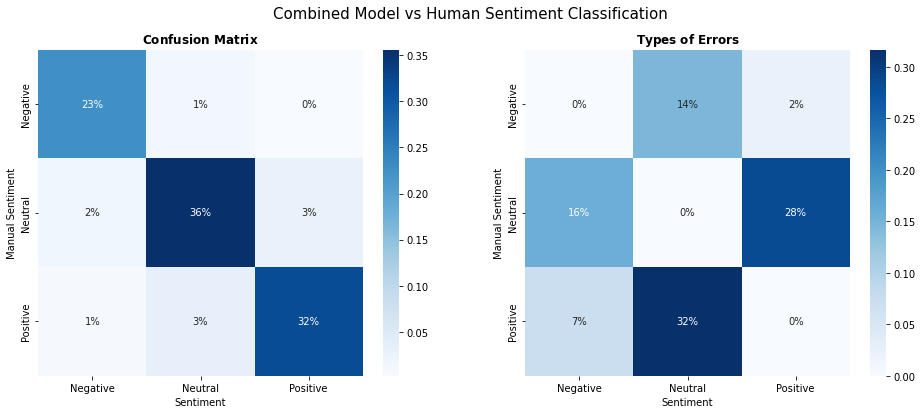

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

conf_mat = pd.crosstab(agree_df['Manual Sentiment'], agree_df['Sentiment'])
sns.heatmap(conf_mat / conf_mat.sum().sum(), ax=axes[0], annot=True, fmt='.0%', cmap='Blues')
axes[0].set_title('$\\bf{Confusion\,\,Matrix}$')

error_rates = conf_mat.copy()
for i in range(len(error_rates)):
    error_rates.iloc[i,i] = 0
sns.heatmap(error_rates / error_rates.sum().sum(), ax=axes[1], annot=True, fmt='.0%', cmap='Blues')
axes[1].set_title('$\\bf{Types\,\,of\,\,Errors}$')

plt.suptitle('Combined Model vs Human Sentiment Classification', fontsize=15, y=0.98)
plt.show()

In [30]:
neu_pos = agree_df[(agree_df['Manual Sentiment'] == 'Neutral') & (agree_df['Sentiment'] == 'Positive')]
neu_pos = neu_pos['Headlines'].sample(7).values.tolist()
print('\033[1m' + 'Sentences w/ Human Label: Neutral, Combined Model Prediction: Positive' + '\033[0m')
for row in neu_pos:
    print(f'  "{row}"')
    
pos_neu = agree_df[(agree_df['Manual Sentiment'] == 'Positive') & (agree_df['Sentiment'] == 'Neutral')]
pos_neu = pos_neu['Headlines'].sample(7).values.tolist()
print('\n\033[1m' + 'Sentences w/ Human Label: Positive, Combined Model Prediction: Neutral' + '\033[0m')
for row in pos_neu:
    print(f'  "{row}"')

Sentences w/ Human Label: Neutral, Combined Model Prediction: Positive
  "Timex posts Q4 net profit at Rs 2.47 crore"
  "Sebi eases rules for market making in illiquid equity cash segment"
  "City CU Welcomes DART Members DALLAS-City CU welcomes the members of DART FCU as they merge with City CU"
  "Sectors that see divestment will be more attractive going forward: Anish Damania, IDFC Sec"
  "The GeoSolutions team further provides an intriguing new technology combining GPS and Mobile-based technologies together with Internet-based social networking"
  "State-run companies an inexpensive play on PM Modi reforms: Morgan Stanley"
  "Marked improvement across segments; agri space just one of them: Pankaj Pandey, ICICIdirect.com"

Sentences w/ Human Label: Positive, Combined Model Prediction: Neutral
  "Janus Overseas Fund buys 12.3 lakh Strides Arcolab shares"
  "GE India to acquire 70% stake in Advanced Systek"
  "Diageo Plc, United Spirits open offer for Pioneer Distilleries from August 

In [52]:
disagree_df = raw_df[raw_df['GPT Sentiment'] != raw_df['FinRoberta Sentiment']]
disagree_df = disagree_df[['Headlines', 'GPT Sentiment', 'FinRoberta Sentiment', 'Manual Sentiment']]
gpt_perf = (disagree_df[disagree_df['GPT Sentiment'] == disagree_df['Manual Sentiment']].shape[0] / 
            disagree_df.shape[0])
finroberta_perf = (disagree_df[disagree_df['FinRoberta Sentiment'] == disagree_df['Manual Sentiment']].shape[0] / 
                   disagree_df.shape[0])

print(f'GPT performance when models disagree: {gpt_perf:.2%}')
print(f'FinRoberta performance when models disagree: {finroberta_perf:.2%}')

GPT performance when models disagree: 52.25%
FinRoberta performance when models disagree: 43.16%


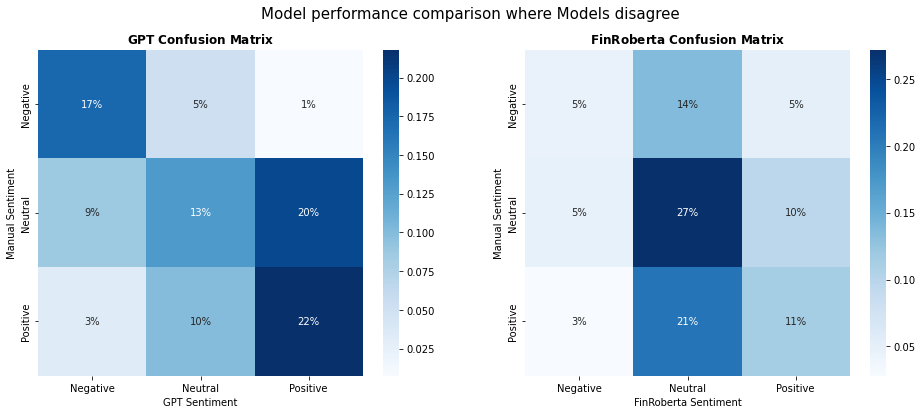

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

conf_mat = pd.crosstab(disagree_df['Manual Sentiment'], disagree_df['GPT Sentiment'])
sns.heatmap(conf_mat / conf_mat.sum().sum(), ax=axes[0], annot=True, fmt='.0%', cmap='Blues')
axes[0].set_title('$\\bf{GPT\,\,Confusion\,\,Matrix}$')

conf_mat = pd.crosstab(disagree_df['Manual Sentiment'], disagree_df['FinRoberta Sentiment'])
sns.heatmap(conf_mat / conf_mat.sum().sum(), ax=axes[1], annot=True, fmt='.0%', cmap='Blues')
axes[1].set_title('$\\bf{FinRoberta\,\,Confusion\,\,Matrix}$')

plt.suptitle('Model performance comparison where Models disagree', fontsize=15, y=0.98)
plt.show()

In [54]:
print('\033[1m' + 'Headlines where models disagree (Human/GPT/FinRoberta):' + '\033[0m')
for row in disagree_df.sample(8).values.tolist():
    print(f'  ({row[3]}/{row[1]}/{row[2]})\t"{row[0]}"')

Headlines where models disagree (Human/GPT/FinRoberta):
  (Negative/Negative/Neutral)	"Switch out of Piramal: Deepak Mohoni"
  (Neutral/Positive/Neutral)	"Samvat survey: D-Street sees Sensex at 33k by next Diwali"
  (Positive/Neutral/Positive)	"Metals and mining companies will now have to operate more efficiently to generate profits: Pramod Gubbi"
  (Neutral/Negative/Neutral)	"Six event-risks to track which may impact markets in near term: BofA-ML"
  (Negative/Negative/Neutral)	"( ADPnews ) - Dec 1, 2009 - Finnish cutlery and hand tools maker Fiskars Oyj Abp ( HEL : FISAS ) said today that it will make redundant a total of 18 office and management staff members of its subsidiary Iittala Group Ltd."
  (Negative/Negative/Positive)	"Compared with the FTSE 100 index, which rose 36.7 points ( or 0.6 % ) on the day, this was a relative price change of -0.2 %"
  (Negative/Negative/Neutral)	"Sell Bank of Baroda with target price of Rs 500: Ashwani Gujral"
  (Negative/Neutral/Negative)	"2014 Lo

### Findings

- Both models exhibit similar performance, with approximately 80% accuracy compared to human annotations.
- The primary disagreement between human annotations and Chat-GPT occurs in distinguishing between neutral 
and positive sentiments.
    - Upon manual inspection it is not clear which is correct.
- FinRoberta has a tendency to over-classify instances as neutral.
- When human annotations and FinRoberta disagree, it is often due to FinRoberta misclassifying instances.
- By combining the outputs of both models, we can eliminate about 25% of the data and achieve 90% 
accuracy on the remaining data.
- For instances where the models disagree, the performance of both models drops to 45-50% accuracy.

## Test set

In [55]:
test = pd.read_csv('../../data/fixed-data/sentiment-test.csv')
test.head()

,Headlines,Sentiment
0,"deutsche bank slashes 7,000 jobs, with city li...",Negative
1,lm vs. trow which stock should value investors...,Neutral
2,lemaitre vascular a strong buy on impressive q4,Positive
3,jack in the box 3 after ebitda impresses,Positive
4,silicom ltd 2016 q4 - results - earnings call ...,Neutral


In [56]:
# Class distribution
print(test.groupby('Sentiment')['Headlines'].count() / len(test))

Sentiment
Negative    0.248317
Neutral     0.472897
Positive    0.278786
Name: Headlines, dtype: float64


## Train set

In [57]:
train = pd.read_csv('../../data/fixed-data/sentiment-train.csv')
val = pd.read_csv('../../data/fixed-data/sentiment-val.csv')
train = pd.concat([train, val], ignore_index=True)
print(train.groupby('Sentiment')['Headlines'].count() / len(train))

Sentiment
Negative    0.248664
Neutral     0.472947
Positive    0.278389
Name: Headlines, dtype: float64


In [58]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436529 entries, 0 to 436528
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Headlines  436529 non-null  object
 1   Sentiment  436529 non-null  object
dtypes: object(2)
memory usage: 6.7+ MB


,Headlines,Sentiment
count,436529,436529
unique,436528,3
top,govt transformation plan strengthens economy chua,Neutral
freq,2,206455


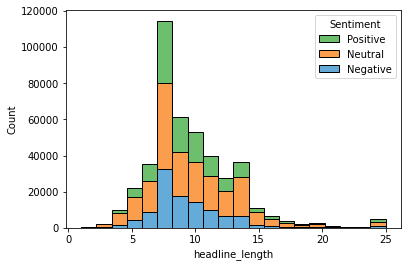

In [59]:
train['headline_length'] = train['Headlines'].astype(str).apply(lambda x: min(len(x.split()), 25))
color_dict = {'Positive': '#3ca83c', 'Neutral': '#f97d11', 'Negative': '#318fce'}
sns.histplot(data=train, x='headline_length', hue='Sentiment', multiple='stack', bins=20,
             palette=color_dict, hue_order=['Positive', 'Neutral', 'Negative'])
plt.show()

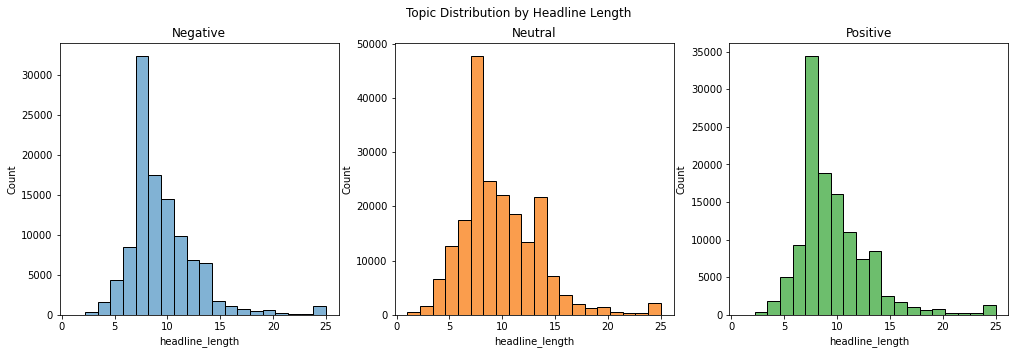

In [60]:
fig, axes = plt.subplots(ncols=3, figsize=(17, 5))
negative = train[train['Sentiment'] == 'Negative']
neutral = train[train['Sentiment'] == 'Neutral']
positive = train[train['Sentiment'] == 'Positive']

sns.histplot(data=negative, x='headline_length', color='#5799c6', multiple='stack',
             bins=20, ax=axes[0])
sns.histplot(data=neutral, x='headline_length', color='#f97d11', multiple='stack',
             bins=20, ax=axes[1])
sns.histplot(data=positive, x='headline_length', color='#3ca83c', multiple='stack',
             bins=20, ax=axes[2])

fig.suptitle('Topic Distribution by Headline Length')
axes[0].set_title('Negative')
axes[1].set_title('Neutral') 
axes[2].set_title('Positive')
plt.show()

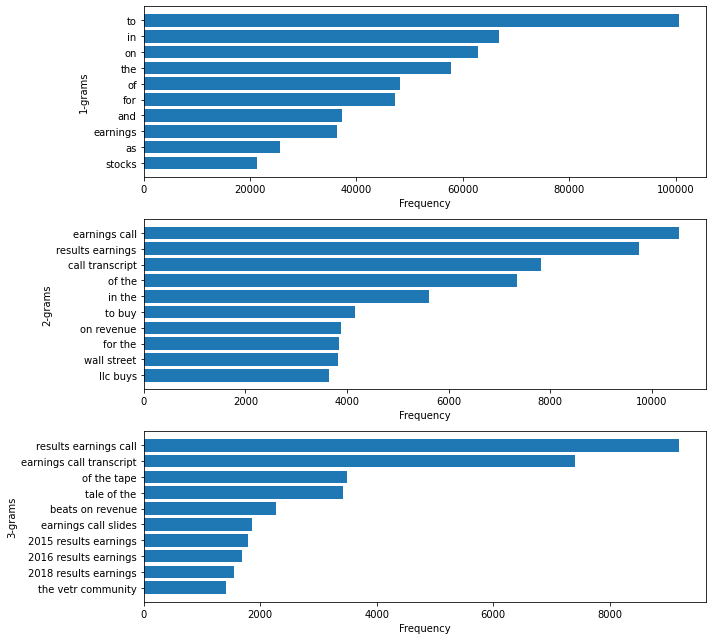

In [61]:
from sklearn.feature_extraction.text import CountVectorizer


def get_ngrams(corpus, ngrams=1, relative=False):
    """Get all n-grams from a corpus of text.
    
    Args:
        corpus: A list of strings representing the text documents.
        ngrams: The size of the n-grams to be extracted (default: 1).
        relative: If True, returns relative frequencies (default: False).
    
    Returns:
        A tuple containing two lists: n-gram words and their corresponding frequencies.
    """
    vec = CountVectorizer(ngram_range=(ngrams, ngrams)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    words, frequencies = zip(*words_freq)
    if relative:
        frequencies = frequencies / np.sum(frequencies)
    return words, frequencies


def plot_top_ngrams(ax, corpus, ngrams=1, top_k=10):
    """Plot the top k n-grams from a corpus of text."""
    words, frequencies = get_ngrams(corpus, ngrams=ngrams)
    words, frequencies = words[:top_k], frequencies[:top_k]
    ax.barh(words, frequencies)
    ax.invert_yaxis()
    ax.set_xlabel('Frequency')
    ax.set_ylabel(f'{ngrams}-grams')


fig, axes = plt.subplots(3, 1, figsize=(10, 9))
plot_top_ngrams(axes[0], train['Headlines'], ngrams=1)
plot_top_ngrams(axes[1], train['Headlines'], ngrams=2)
plot_top_ngrams(axes[2], train['Headlines'], ngrams=3)
plt.tight_layout()
plt.show()

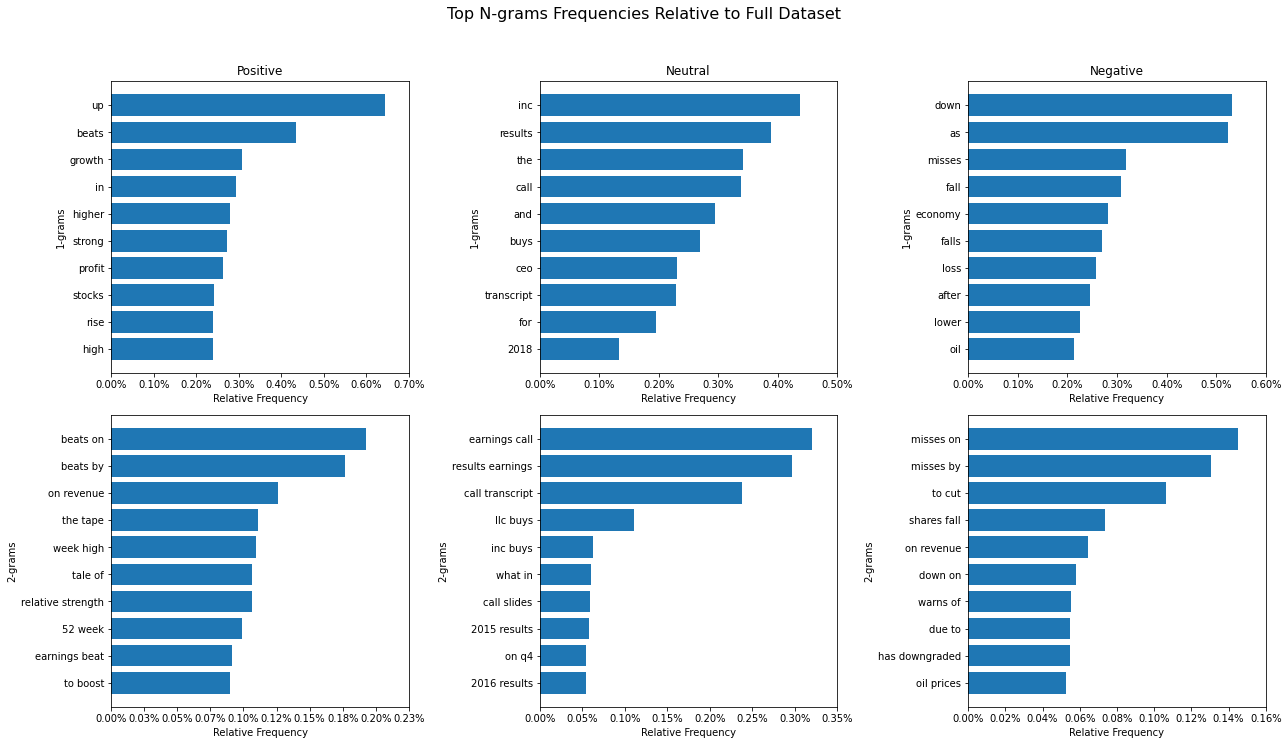

In [62]:
def plot_top_ngrams_relative(ax, corpus, total_counts, ngrams=1, top_k=10):
    """ Plot the top k n-grams relative to the total dataset for a given corpus.
    
    I.e. if 'bull' is 0.2% of the total dataset and 0.6% of the corpus, then the relative
    frequency of 'bull' is 0.6 - 0.2 = 0.4 %.
    
    Args:
        ax: A matplotlib axes object for plotting.
        corpus: A list of strings representing the text documents.
        total_counts: A dictionary containing the total counts of n-grams for all sentiments.
        ngrams: The size of the n-grams to be extracted (default: 1).
        top_k: The number of top n-grams to display (default: 10).
    """
    word_freq = get_ngrams(corpus, ngrams=ngrams, relative=True)
    relative_word_freq = [(w, f - total_counts[w]) for w, f in zip(*word_freq)]
    words_freq = sorted(relative_word_freq, key=lambda x: x[1], reverse=True)[:top_k]
    words, relative_frequencies = zip(*words_freq)

    ax.barh(words, relative_frequencies)
    ax.invert_yaxis()
    ax.set_xlabel('Relative Frequency')
    ax.set_ylabel(f'{ngrams}-grams')
    # Set x-axis to percentage
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(['{:,.2%}'.format(x) for x in xticks])


total_1ngrams = get_ngrams(train['Headlines'], ngrams=1, relative=True)
total_1ngrams = dict(zip(*total_1ngrams))
total_2ngrams = get_ngrams(train['Headlines'], ngrams=2, relative=True)
total_2ngrams = dict(zip(*total_2ngrams))

unique_sentiments = ['Positive', 'Neutral', 'Negative']
num_sentiments = len(unique_sentiments)
fig, axes = plt.subplots(2, num_sentiments, figsize=(6 * num_sentiments, 10))

for col, sentiment in enumerate(unique_sentiments):
    headlines = train[train['Sentiment'] == sentiment]['Headlines']
    axes[0, col].set_title(sentiment)
    plot_top_ngrams_relative(axes[0, col], headlines, total_counts=total_1ngrams, ngrams=1)
    plot_top_ngrams_relative(axes[1, col], headlines, total_counts=total_2ngrams, ngrams=2)

fig.suptitle('Top N-grams Frequencies Relative to Full Dataset', fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

## Key Findings

After analyzing the dataset, the following key findings have emerged:

- The dataset is somewhat balanced, with 47% neutral headlines, 28% positive and 25% negative headlines.
- The distribution of word lengths is similar between all classes, which is a positive sign for model training.
- The problem with the high frequency of `analyst blog` n-grams has been resolved.

Overall, the dataset looks very promising and is ready to be used for training models.

### Earlier Findings

<span style="color: #999999">*This section contains the findings from the previous version of the dataset.*</span>

- Duplicates should be removed in the pre-processing pipeline.
- The amount of `analyst blog` n-grams should be looked into, as they are very frequent in the dataset 
compared to any other ngrams.
- The word `stocks` is suspiciously bullish. Do some manually testing of models with fictious 
headlines like *"Stocks crashes after the President announces new lockdown"*.

Other than that, the dataset looks promising and is ready to be used for training models.